## Extend iMVP by sliding window

iMVP is very sensitive to the location of the motifs. For some cases, we can easily find out the enriched but non-aligned patterns by ourselves, but sometime it very hard. To extend the usage of iMVP on non-aligned patterns, one way is to perform sliding windows sampling from the sequences, so that the patterns can somehow be aligned among these windows. After clustering, there will be a lot of small and non-aligned clusters. Since the motif patterns are now known, we can use motif comparison and alignment tool, such as Tomtom, to further align the similar motifs.

There are some drawbacks in the sliding window strategy: (1) it will consume much more resources (CPU time and memory); (2) it will reduce the resolution of iMVP.

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan
import logging
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
logging.captureWarnings(True)
# for Linux only, load font file
# mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
np.random.seed(42)

In [2]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        try:
            id = int(i.replace("cluster_", "").replace(".png", ""))
        except ValueError:
            id = i.replace("cluster_", "").replace(".png", "")
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if len(file_list_format) > 1:
        for ax, image in zip(*[axes.reshape(-1), file_list_format]):
            fn, id = image
            img = plt.imread(prefix+"/"+fn)
            _ = ax.imshow(img)
            ax.set_title("cluster_{}".format(id))
        for ax in axes.reshape(-1):
            ax.axis("off")
    else:
        image = file_list_format[0]
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = axes.imshow(img)
        axes.set_title("cluster_{}".format(id))
        axes.axis("off")
    plt.tight_layout()

In [3]:
def simulation(fn):
    # intotal 21 nt
    data = {"TF":{}, "motif_F10": {}}
    df_TF = pd.read_csv(fn, index_col=None, header=0)
    df_TF = df_TF[df_TF["TF"].isin(["Pdx1"])] # NFKB1
    TFs = set(df_TF["TF"].tolist())
    num_of_motifs = [500] # np.random.randint(50, 5000, len(TFs))
    basespace = df_TF.columns[0:4]
    N = 0
    
    max_len = 50
    
    for TF, sim_num in zip(*[TFs, num_of_motifs]):
        motif_matrix = df_TF[df_TF["TF"] == TF]
        right_max = max_len - motif_matrix.shape[0]
        # pos = np.random.randint(0, right_max)
        rand_dist = np.random.normal(loc=100, scale=200, size=right_max)
        rand_dist = rand_dist - rand_dist.min()
        rand_dist = rand_dist / np.sum(rand_dist)
        rand_dist = np.sort(rand_dist)
        print(rand_dist)
        all_bases = []
        for idx, row in motif_matrix.iterrows():
            all_bases.append(np.random.choice(basespace, sim_num, p=row[basespace]/row[basespace].sum()))
        for i in zip(*all_bases):
            core = "".join(i)
            pos = np.random.choice(range(0,right_max), 
                                   p= rand_dist)
            left = "".join(np.random.choice(basespace, pos)).lower()
            right = "".join(np.random.choice(basespace, max_len - pos - len(core))).lower()
            sim_seq = left + core + right
            data["TF"][N] = TF
            data["motif_F10"][N] = sim_seq.upper()
            N += 1
    # noise 
    for i in range(500):
        data["TF"][N] = "random_noise"
        data["motif_F10"][N] = "".join(np.random.choice(basespace, 50))
        N += 1
    return pd.DataFrame(data)
    

In [4]:
df = simulation("TFs.csv")

[0.         0.00059495 0.00301068 0.00686034 0.00701994 0.00809874
 0.0094754  0.01037123 0.01156757 0.01214315 0.01348729 0.0174158
 0.01742949 0.01792134 0.01815097 0.01911167 0.01915969 0.01918934
 0.02127101 0.02139169 0.02212964 0.02212985 0.02223708 0.02335941
 0.02364946 0.02495954 0.02599869 0.02655522 0.02733043 0.02765738
 0.02781131 0.0282358  0.02916285 0.02995095 0.03150297 0.03209094
 0.03343921 0.03460343 0.03497495 0.03568173 0.0439295  0.04466541
 0.04538595 0.048888  ]


In [5]:
df

,TF,motif_F10
0,Pdx1,CTTGTGGCCACCGCGGCAATTCTAATTCAGTGTCATAGCACAGGCG...
1,Pdx1,CCAATAAATGAATGACTAACCTTCTCACCGCCGCTAATTTGAGATG...
2,Pdx1,CGTTAGAACCTATGAAGGTTGTGAACAGTCTGACGCCTTAATCAGT...
3,Pdx1,CGGTGGATCGCCAGTGCTGCCAAACGAGATTACAACTGACCTAATG...
4,Pdx1,CTTCTGAGTCCGCTGCAATCTGAGCTTTGAGGCCCACTAATTACCA...
...,...,...
995,random_noise,GTCTTTATGAAATCTTCTGCGGAACTGTGAAACGTGTTTGACCACT...
996,random_noise,AAGTTTCTCGCTAGTTTGAAATCTAGCCTGCATTAAACGCGTGACA...
997,random_noise,CAGTATCTTTCGGGAACGTGACGAATGTGCGTTAGGCATGACAGGC...
998,random_noise,AATACATTATTATTACCTGGAACGAGGTTGCAACTTCCTGTGAAGG...


In [6]:
df.groupby("TF").count()

,motif_F10
TF,
Pdx1,500
random_noise,500


In [7]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCG"])

def onehot_enc(row):
    seq = [[i] for i in row["motif_F10"].upper()]
    return enc.transform(seq).toarray().reshape(-1)

In [8]:
onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

In [9]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

In [10]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean'):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap, metric=metric)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [11]:
def cluster_HDBSCAN(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True, optimize=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    if optimize == True:
        validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)
        param_dist = {'min_samples': [10, 20,50,100], # 1,
                      'min_cluster_size':[100,200, 300],  
                      'cluster_selection_method' : ['eom'],
                     }
        n_iter_search = 100
        random_search = RandomizedSearchCV(model
                                           ,param_distributions=param_dist
                                           ,n_iter=n_iter_search
                                           ,scoring=validity_scorer 
                                           ,random_state=42)
        random_search.fit(X)
        print(random_search.best_params_)
        model = random_search.best_estimator_
    yhat = model.fit(X)
    
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    
    
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [43]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column]))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A dna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A dna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A dna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [13]:
_, _, df_UMAP = UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean')

UMAP
UMAP time: 5.668207883834839 sec
UMAP RAM: 0.0 MB



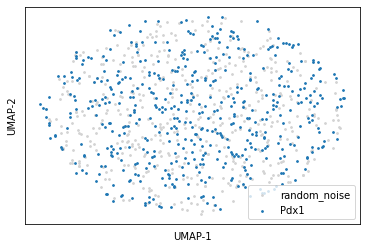

In [14]:
fig, ax = plt.subplots()
for TF in set(df_UMAP["TF"].tolist()):
    if TF != "random_noise":
        subdf = df_UMAP[df_UMAP["TF"] == TF]
        ax.scatter(subdf["X"], subdf["Y"], s=3, label=TF)
    else:
        subdf = df_UMAP[df_UMAP["TF"] == TF]
        ax.scatter(subdf["X"], subdf["Y"], s=3, label=TF, zorder=0, color="lightgray")
plt.legend()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.savefig("ground_truth.jpg", dpi=300)

{'min_samples': 10, 'min_cluster_size': 100, 'cluster_selection_method': 'eom'}
HDBSCAN soft clustering time: 1.0007996559143066 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: -1
Cluster
-1    1000
Name: Cluster, dtype: int64


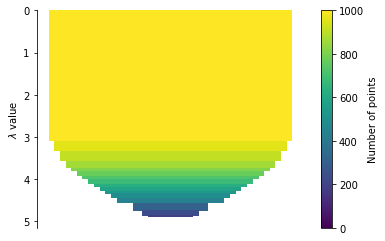

In [15]:
# _, _, df_HDBSCAN, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=10, soft_clustering=False, optimize=False)
_, _, df_HDBSCAN, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=1, soft_clustering=False, optimize=True)

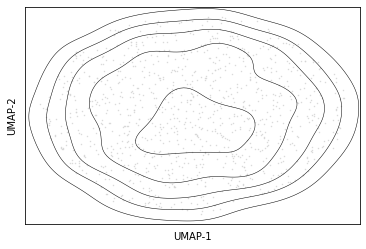

In [16]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN, title=None, cluster_col="Cluster")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.savefig("HDBSCAN.jpg", dpi=300)

In [17]:
temp = []
wind_size = 20
step = 1
for idx, row in df.iterrows():
    seq = row["motif_F10"]
    for i in range(0, len(seq)-wind_size, step):
        temp.append(seq[i:i+wind_size])

df2 = pd.DataFrame()
df2["motif_F10"] = temp

In [18]:
df2

,motif_F10
0,CTTGTGGCCACCGCGGCAAT
1,TTGTGGCCACCGCGGCAATT
2,TGTGGCCACCGCGGCAATTC
3,GTGGCCACCGCGGCAATTCT
4,TGGCCACCGCGGCAATTCTA
...,...
29995,GCTTACTGTGATGAAATAAG
29996,CTTACTGTGATGAAATAAGA
29997,TTACTGTGATGAAATAAGAT
29998,TACTGTGATGAAATAAGATC


In [19]:
onehot_input2 = []
for idx, row in df2.iterrows():
    onehot_input2.append(onehot_enc(row))
onehot_input2 = np.array(onehot_input2)

In [20]:
_, _, df_UMAP2 = UMAP(onehot_input2, df2, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean')

UMAP
UMAP time: 33.22268080711365 sec
UMAP RAM: 0.0 MB



HDBSCAN soft clustering time: 2.1844706535339355 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 11
Cluster
-1     13563
 1       532
 2       288
 3       497
 4       435
 5       598
 6       399
 7       576
 8       230
 9       434
 10    12065
 11      383
Name: Cluster, dtype: int64


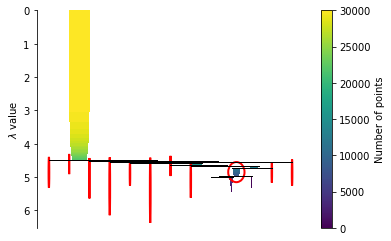

In [21]:
_, _, df_HDBSCAN2, _ = cluster_HDBSCAN(df_UMAP2, min_cluster_size=200, min_samples=200, soft_clustering=False, optimize=False)
# _, _, df_HDBSCAN2, _ = cluster_HDBSCAN(df_UMAP2, min_cluster_size=100, min_samples=1, soft_clustering=False, optimize=True)

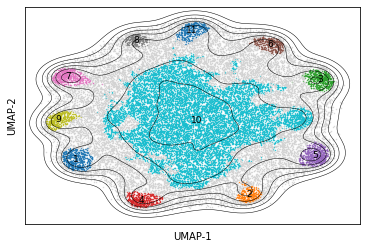

In [22]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN2, title=None, cluster_col="Cluster")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.savefig("HDBSCAN_sliding.jpg", dpi=300)

In [44]:
extract_fasta_and_draw_motifs("iMVP_out", df_HDBSCAN2)

===============  iMVP_out ===============
Cluster #1: 532
Cluster #2: 288
Cluster #3: 497
Cluster #4: 435
Cluster #5: 598
Cluster #6: 399
Cluster #7: 576
Cluster #8: 230
Cluster #9: 434
Cluster #10: 12065
Cluster #11: 383
Cluster #-1: 13563


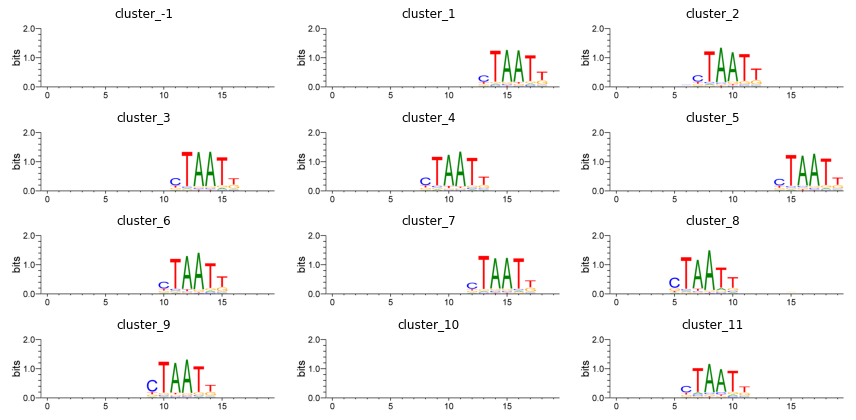

In [45]:
show_logos_cols("./iMVP_out/logos_bits_png/")
plt.savefig("clusters.jpg", dpi=300)

In [25]:
with open("sim_out.fa", "w") as output:
    for idx, row in df.iterrows():
        output.write(">{}_{}\n{}\n".format(row["TF"], idx, row["motif_F10"]))

In [26]:
extract_fasta_and_draw_motifs("iMVP_out", df_HDBSCAN)

===============  iMVP_out ===============
Cluster #-1: 1000


In [32]:
from weblogo import *

def cal_bits_from_fasta(df, ID, ID_label="Cluster", motif_label="motif_F10", write_output=None):
    subdf = df[df[ID_label]==ID]
    count_data = {}
    for _, row in subdf.iterrows():
        for idx, base in enumerate(list(row[motif_label])):
            if idx not in count_data:
                count_data[idx] = {"A":0, "C":0, "G": 0, "T": 0}
            count_data[idx][base] += 1
    seqs = []
    
    count_df = pd.DataFrame.from_dict(count_data).T
    seqs = count_df.values

    # fin = open(fn)
    #  seqs = read_seq_data(fin)
    seqs = np.array(seqs)
    logodata = LogoData.from_counts(counts=seqs, alphabet='ACGT')

    temp = []
    for i in range(logodata.counts.shape[0]):
        temp.extend(list(logodata.entropy[i]*logodata.counts[i]/logodata.counts[i].sum()))
        if write_output is not None:
            write_output.write("{}\t{}\t{}\t{}\n".format(logodata.counts[i][0], logodata.counts[i][1], logodata.counts[i][2], logodata.counts[i][3]))
    write_output.write("\n")
    # reorder
    temp2 = temp[::4] + temp[1::4] + temp[2::4] + temp[3::4]
    return np.array(temp2)

with open("temp.mat", "w") as count_mat_file:
    temp = []
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]:
        temp.append(cal_bits_from_fasta(df_HDBSCAN2, i, write_output=count_mat_file))

'''
m1 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_1.fa")
m2 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_2.fa")
m3 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_3.fa")
m4 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_4.fa")
m5 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_5.fa")
'''

'\nm1 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_1.fa")\nm2 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_2.fa")\nm3 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_3.fa")\nm4 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_4.fa")\nm5 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_5.fa")\n'

In [33]:
!matrix2meme -dna < temp.mat > temp.meme

In [34]:
!tomtom -oc tomtom_out temp.meme temp.meme

Provide at least 50 motifs for accurate p-value computation.
The output directory 'tomtom_out' already exists.
Its contents will be overwritten.
Processing query 1 out of 10 
# Computing q-values.
#   Cannot estimate pi_0 accurately from fewer than 100 p-values.
#   Total p-values = 20. Using pi_zero = 1.0.
Processing query 2 out of 10 
# Computing q-values.
#   Cannot estimate pi_0 accurately from fewer than 100 p-values.
#   Total p-values = 20. Using pi_zero = 1.0.
Processing query 3 out of 10 
# Computing q-values.
#   Cannot estimate pi_0 accurately from fewer than 100 p-values.
#   Total p-values = 20. Using pi_zero = 1.0.
Processing query 4 out of 10 
# Computing q-values.
#   Cannot estimate pi_0 accurately from fewer than 100 p-values.
#   Total p-values = 20. Using pi_zero = 1.0.
Processing query 5 out of 10 
# Computing q-values.
#   Cannot estimate pi_0 accurately from fewer than 100 p-values.
#   Total p-values = 20. Using pi_zero = 1.0.
Processing query 6 out of 10 
# Com

In [35]:
df_motif_sim = pd.read_table("./tomtom_out/tomtom.tsv", index_col=None, header=0, comment="#")

In [36]:
df_motif_sim

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,1,1,0,0.000000e+00,0.000000e+00,0.000000e+00,20,TCTCAGAGCGCGCCTAATTC,TCTCAGAGCGCGCCTAATTC,+
1,1,5,1,1.546180e-15,1.546180e-14,1.546180e-14,19,TCTCAGAGCGCGCCTAATTC,ATCGCAGAGCCGTCCTAATT,+
2,1,3,-2,6.004060e-13,6.004060e-12,4.002710e-12,18,TCTCAGAGCGCGCCTAATTC,CTTGAGCGCTCCTAATTGAC,+
3,1,7,-1,1.058730e-12,1.058730e-11,5.293630e-12,19,TCTCAGAGCGCGCCTAATTC,GTCTCAGCGATCCTAATTGA,+
4,1,6,-3,5.322930e-11,5.322930e-10,2.129170e-10,17,TCTCAGAGCGCGCCTAATTC,ATAAGCTATCCTAATTCGTA,+
...,...,...,...,...,...,...,...,...,...,...
95,10,3,5,5.942300e-09,5.942300e-08,1.980770e-08,15,CAGCTCCTAATTCGGGACGT,CTTGAGCGCTCCTAATTGAC,+
96,10,7,6,1.989550e-08,1.989550e-07,5.684430e-08,14,CAGCTCCTAATTCGGGACGT,GTCTCAGCGATCCTAATTGA,+
97,10,1,7,2.477480e-08,2.477480e-07,6.193690e-08,13,CAGCTCCTAATTCGGGACGT,TCTCAGAGCGCGCCTAATTC,+
98,10,2,1,5.819420e-08,5.819420e-07,1.293200e-07,19,CAGCTCCTAATTCGGGACGT,TGTGCTCCTAATTGGGGAGG,+


In [37]:
df_motif_sim_pivot = df_motif_sim.pivot(index="Query_ID", columns="Target_ID", values="q-value")
df_motif_sim_pivot[df_motif_sim_pivot==0] = 1e-10

<AxesSubplot:xlabel='Target_ID', ylabel='Query_ID'>

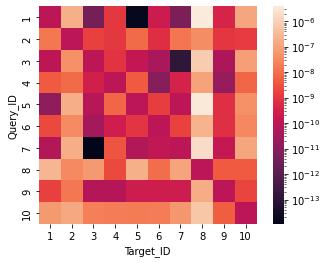

In [38]:
from matplotlib.colors import LogNorm, Normalize
sns.heatmap(data=df_motif_sim_pivot, square=True, norm=LogNorm(), vmax=0)

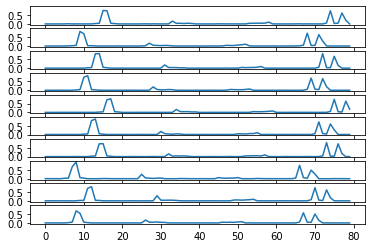

In [39]:
fig, axes = plt.subplots(len(temp),1,sharey=True)
for idx, item in enumerate(temp):
    axes[idx].plot(item)